In [77]:
from pathlib import Path
import pickle
import itertools

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import seaborn as sns

import nb_utils

In [78]:
def features_for_dim(pd, dim):
	# b: birth, d: death
	b, d, _ = pd[pd[:,2] == dim].T
	if dim == 0:
		assert d[-1] == np.inf
		d[-1] = 1
	with np.errstate(invalid='ignore', divide='ignore'):
		return [
			mean_bd := np.c_[b, d].mean(axis=0),
			mean_bd**2,
			np.nan_to_num(1/mean_bd + np.log(mean_bd)), # fix divide by zero
			np.c_[b, d].std(axis=0),
			[np.mean(b - d)],
			[np.mean(b - d)**2],
			[np.mean((b + d) / 2)],
			[np.mean((b + d) / 2)**2],
		]

features = {
	'avg_birth_death': 2,
	'avg_birth_death_squared': 2,
	'avg_birth_death_inverted' : 2,
	'std_birth_death': 2,
	'avg_life': 1,
	'avg_life_squared': 1,
	'avg_half_life': 1,
	'avg_half_life_squared': 1
}

combinations = [*itertools.chain(*(
	itertools.combinations(features.keys(), r)
	for r in range(1, len(features) + 1)
))]

def features_all_dims(pd):
	arrs = [np.concatenate(features_for_dim(pd, dim)) for dim in (0, 1)]
	return np.vstack(arrs)

In [99]:
def get_labeled_data(task, files):
	print(f'task {task}')
	gen_gaps = nb_utils.gen_gaps[task]
	pds = [*map(np.load, files)]
	X = np.stack([*map(features_all_dims, pds)])
	y = np.array([gen_gaps[f.name.split('.')[0]] for f in files])
	return X, y

In [80]:
def feature_mask(included):
	return np.concatenate([
		np.full(length, 1 if feature in included else 0)
		for feature, length in features.items()
	])

def run_experiment(X, y, tries, model_fn):
	results = np.empty((len(combinations), tries))
	splits = [*ShuffleSplit(tries, test_size=0.3).split(X)]
	for i, combo in enumerate(tqdm(combinations)):
		X_masked = X[:,:,np.where(feature_mask(combo))[0]]
		X_flattened = X_masked.reshape((len(X), -1))
		for j, (train, test) in enumerate(splits):
			reg = model_fn().fit(X_flattened[train], y[train])
			results[i, j] = reg.score(X_flattened[test], y[test])
	return results

## Model performance
We look at the model performance for the model with the best performing selection of features (by average R2) and at the models incorporating all features

In [81]:
def extract_best(results, ):
	return max(results, key=np.mean)

def extract_all(results):
	return results[-1]

In [101]:
def results_for_sampler(task, files: list[Path]):
	task_name_date = files[0].parts[-4:-1]
	results_file = Path('results') / ("-".join(task_name_date) + '.npy')
	try:
		return np.load(results_file)
	except FileNotFoundError:
		print('Calculating', '/'.join(task_name_date))
		X, y = get_labeled_data(task, files)
		results = run_experiment(X, y, 1000, LinearRegression)
		np.save(results_file, results)
		return results

In [83]:
results = {
	sampler: results_for_sampler(files)
	for sampler, files in nb_utils.get_files(1)
}

In [84]:
pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results.values()],
	'Best features': [np.mean(extract_best(res)) for res in results.values()]
}, index=results.keys())

,All features,Best features
AvgImportance,0.600350,0.719903
MaxImportance,0.723637,0.788833
Random,0.771025,0.815547
StratifiedKMeans20000,0.780958,0.824686
StratifiedRandom,0.746796,0.796928


### KDE plots

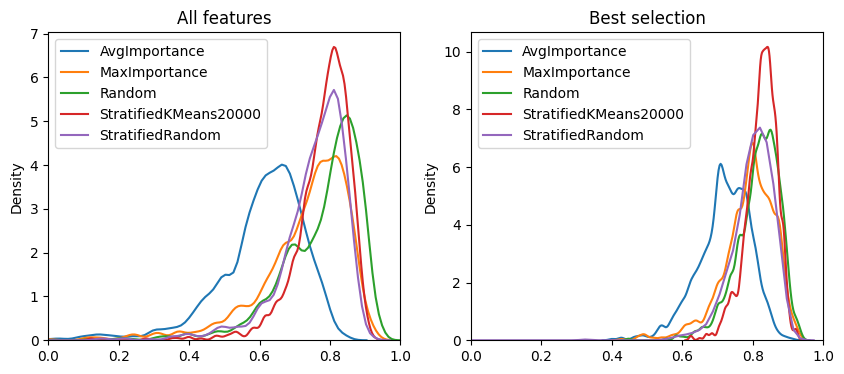

In [93]:
def plot_kdes(samplers, dists, bw=None, ax=None):
	for sampler, dist in zip(samplers, dists):
		ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=sampler)
	ax.legend()
	ax.set_xlim([0,1])
	return ax

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
types = {'All features': extract_all, 'Best selection': extract_best}
for ax, (title, extract) in zip(axs, types.items()):
	plot_kdes(samplers=list(results.keys()),
			dists=[extract(results) for results in results.values()],
			ax=ax, bw=0.12)
	ax.set_title(title)

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         0.,  1.,  0.,  0.,  2.,  0.,  1.,  0.,  0.,  0.,  2.,  1.,  2.,
         1.,  0.,  5.,  2.,  1.,  2.,  3.,  3.,  4.,  2.,  7.,  6.,  7.,
         9., 17., 16., 18., 21., 29., 41., 40., 34., 33., 46., 38., 47.,
        81., 80., 93., 92., 73., 74., 44.,  8.,  8.]),
 array([-0.76530977, -0.74813859, -0.73096742, -0.71379625, -0.69662507,
        -0.6794539 , -0.66228273, -0.64511156, -0.62794038, -0.61076921,
        -0.59359804, -0.57642686, -0.55925569, -0.54208452, -0.52491335,
        -0.50774217, -0.490571  , -0.47339983, -0.45622865, -0.43905748,
        -0.42188631, -0.40471514, -0.38754396, -0.37037279, -0.35320162,
        -0.33603044, -0.31885927, -0.3016881 , -0.28451693, -0.267345

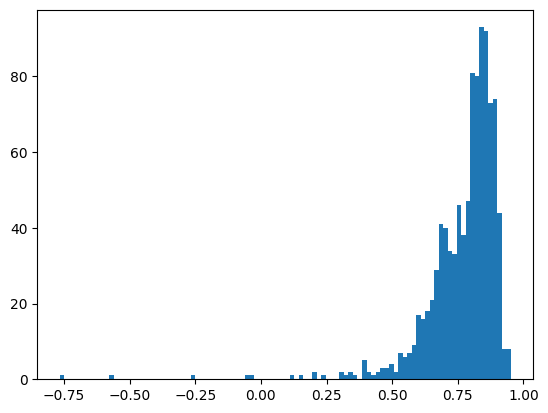

In [96]:
plt.hist(results['Random'][-1], 100)

In [97]:
import pandas as pd

data = {
	sampler: [f in combinations[np.argmax(np.mean(results, 1))] for f in features]
	for sampler, results in results.items()
}
pd.DataFrame(data, index=features.keys()).replace({True: 'X', False: ''})


,AvgImportance,MaxImportance,Random,StratifiedKMeans20000,StratifiedRandom
avg_birth_death,,X,X,,
avg_birth_death_squared,X,,,X,X
avg_birth_death_inverted,,X,X,X,X
std_birth_death,X,X,X,X,X
avg_life,X,X,X,,X
avg_life_squared,,X,,,
avg_half_life,X,,,,
avg_half_life_squared,,X,X,X,X


In [47]:
from statistics import mean

heatmap = np.zeros((len(results), len(features)))
for i, (sampler, res) in enumerate(results.items()):
	for j, feature in enumerate(features):
		r2s = itertools.chain(
			*(res[i] for i, combo in enumerate(combinations) if feature in combo))
		heatmap[i][j] = mean(r2s)

(<Figure size 640x480 with 1 Axes>,
 <AxesSubplot: title={'center': 'Average R2 of selections with feature present'}>)

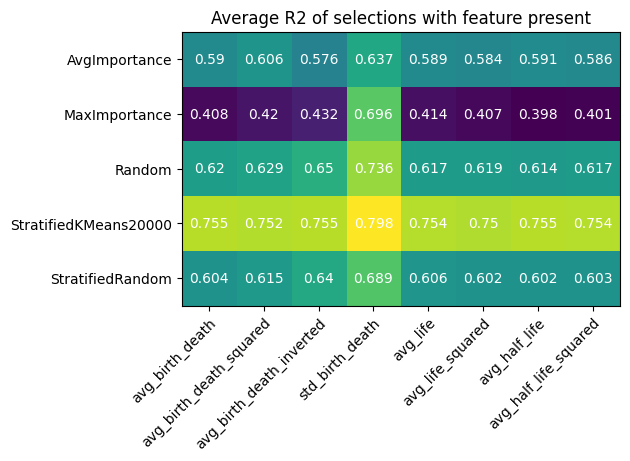

In [49]:
from importlib import reload
reload(nb_utils)

nb_utils.annotated_heatmap(heatmap,
						   title="Average R2 of selections with feature present",
						   x_labels=features.keys(),
						   y_labels=results.keys())

In [73]:
results_random = [
	results_for_sampler(files)
	for files in nb_utils.get_files(1, sampler='Random')
]

Calculating for sampler Random/22.12.21-18.06.40


100%|██████████| 255/255 [06:42<00:00,  1.58s/it]


Calculating for sampler Random/22.12.21-20.38.16


100%|██████████| 255/255 [06:22<00:00,  1.50s/it]


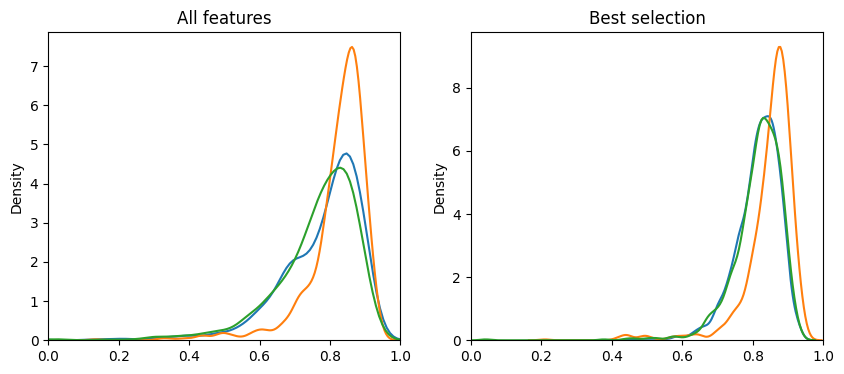

In [76]:
def plot_kdes(samplers, dists, bw=None, ax=None):
	for sampler, dist in zip(samplers, dists):
		ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=sampler)
	ax.set_xlim([0,1])
	return ax

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
types = {'All features': extract_all, 'Best selection': extract_best}
for ax, (title, extract) in zip(axs, types.items()):
	plot_kdes(samplers=['']*len(results_random),
			  dists=[extract(results) for results in results_random],
			  ax=ax, bw=0.2)
	ax.set_title(title)

In [103]:
results = {
	sampler: results_for_sampler(2, files)
	for sampler, files in nb_utils.get_files(2)
}

Calculating for sampler task2/AvgImportance/22.12.29-18.10.57
task 2


  7%|▋         | 18/255 [00:20<04:26,  1.12s/it]


KeyboardInterrupt: 

In [ ]:
pd.DataFrame({
	'All features': [np.mean(extract_all(res)) for res in results.values()],
	'Best features': [np.mean(extract_best(res)) for res in results.values()]
}, index=results.keys())

In [ ]:
### KDE plots
def plot_kdes(samplers, dists, bw=None, ax=None):
	for sampler, dist in zip(samplers, dists):
		ax = sns.kdeplot(dist, ax=ax, bw_method=bw, label=sampler)
	ax.legend()
	ax.set_xlim([0,1])
	return ax

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
types = {'All features': extract_all, 'Best selection': extract_best}
for ax, (title, extract) in zip(axs, types.items()):
	plot_kdes(samplers=list(results.keys()),
			dists=[extract(results) for results in results.values()],
			ax=ax, bw=0.12)
	ax.set_title(title)